In [1]:
#!/usr/bin/python
# -*- coding: utf-8 -*-

import numpy as np
import sys
import os
from matplotlib import pyplot as plt
import pickle
import climtools_lib as ctl
from scipy import stats
import xarray as xr
import glob
import pymannkendall as mk
import cartopy.crs as ccrs
import matplotlib.ticker as mticker

from scipy.interpolate import UnivariateSpline as spline

plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
titlefont = 22
plt.rcParams['figure.titlesize'] = titlefont
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.axisbelow'] = True
plt.rcParams['legend.fontsize'] = 18

#############################################################################

cart_out = '/home/fabiano/Research/lavori/BOTTINO/simple_maps/'

colors = ['black', 'royalblue', 'lightslategray', 'forestgreen', 'orange', 'chocolate', 'maroon', 'violet', 'crimson']
allru = ['pi', 'hist', 'b990', 'b025', 'b050', 'b065', 'b080', 'b100', 'ssp585']

libgfortran.so.3: cannot open shared object file: No such file or directory
No DISPLAY variable set. Switching to agg backend


In [ ]:
cart_in = '/home/fabiano/Research/lavori/BOTTINO/seasmean/'

glomeans, pimean = pickle.load(open(cart_in + 'bottino_glomeans_1000.p', 'rb'))

var = 'tas'
yeamean = pickle.load(open(cart_in + 'bottino_seasmean_2D_{}_1000.p'.format(var), 'rb'))

yeamean_pi = pickle.load(open(cart_in + 'bottino_seasmean_2D_pi.p', 'rb'))

### Mappa con coordinate strette

In [ ]:
%matplotlib inline

In [ ]:
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

fig, ax = ctl.get_cartopy_fig_ax(figsize = (16,9))
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='-')

gl.xlocator = mticker.FixedLocator(np.arange(-180, 180, 10))
gl.ylocator = mticker.FixedLocator(np.arange(-90, 90, 10))
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 15, 'color': 'white'}
gl.ylabel_style = {'size': 15, 'color': 'white'}

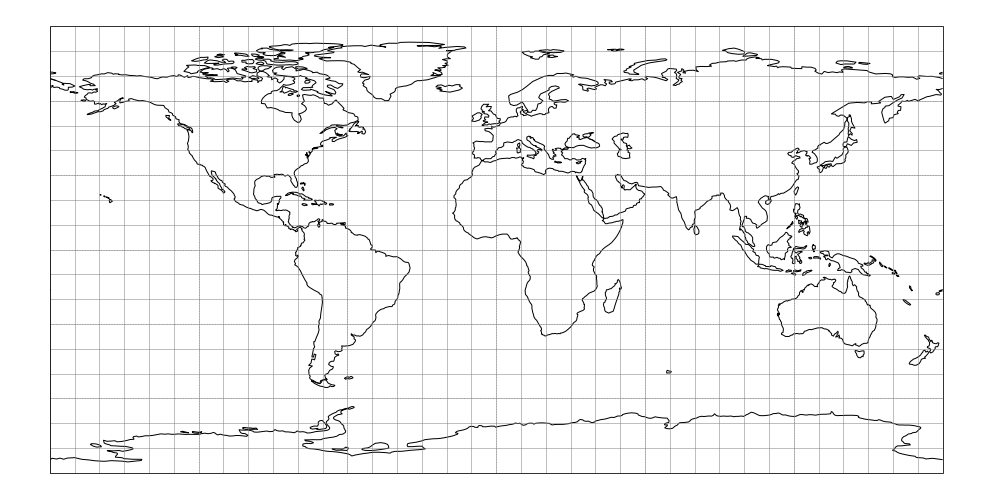

In [ ]:
fig

### -> Temp trend in regioni specifiche: Southern Ocean (Pacific) e North Atlantic

plotto la temp anomaly locale mediata diviso la temp anomaly globale

In [6]:
var = 'tas'

piclim_orig = yeamean_pi[('pi', var)].mean('year')

SO_pac = (150, 280, -60, -40)
N_atl = (-60, -10, 30, 60)

areas = [SO_pac, N_atl]
areanams = ['SO_pac', 'N_atl']

regtemp = dict()

for ru in allru[2:-1]:
    print(ru)
    piclim = ctl.regrid_dataset(piclim_orig, regrid_to_reference=yeamean[(ru, var)])
    for area, nam in zip(areas, areanams):
        deltaclim = yeamean[(ru, var)]-piclim
        varok = ctl.sel_area_xr(deltaclim, area)
        varme = ctl.global_mean(varok)

        regtemp[(ru, nam)] = varme


b990
Regridding...


/home/fabiano/local_bin/anaconda3/envs/ctl4/lib/python3.9/site-packages/xarray/core/dataarray.py:780: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


Regridding completed in 0:00:03.442736
Area:  150 280 -60 -40
Area:  300 350 30 60
b025
Regridding...


/home/fabiano/local_bin/anaconda3/envs/ctl4/lib/python3.9/site-packages/xarray/core/dataarray.py:780: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


Regridding completed in 0:00:02.379954
Area:  150 280 -60 -40
Area:  300 350 30 60
b050
Regridding...


/home/fabiano/local_bin/anaconda3/envs/ctl4/lib/python3.9/site-packages/xarray/core/dataarray.py:780: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


Regridding completed in 0:00:02.359410
Area:  150 280 -60 -40
Area:  300 350 30 60
b065
Regridding...


/home/fabiano/local_bin/anaconda3/envs/ctl4/lib/python3.9/site-packages/xarray/core/dataarray.py:780: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


Regridding completed in 0:00:02.361390
Area:  150 280 -60 -40
Area:  300 350 30 60
b080
Regridding...


/home/fabiano/local_bin/anaconda3/envs/ctl4/lib/python3.9/site-packages/xarray/core/dataarray.py:780: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


Regridding completed in 0:00:02.391316
Area:  150 280 -60 -40
Area:  300 350 30 60
b100
Regridding...


/home/fabiano/local_bin/anaconda3/envs/ctl4/lib/python3.9/site-packages/xarray/core/dataarray.py:780: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


Regridding completed in 0:00:02.356144
Area:  150 280 -60 -40
Area:  300 350 30 60


In [17]:
polydeg = 3
tip = 'expfit' # polyfit, butter, expfit

figs_fit = []

for tip in ['expfit', 'polyfit', 'spline']:
    for area in ['SO_pac', 'N_atl']:
        fig, ax = plt.subplots(figsize = (16,9))
        fig3, ax3 = plt.subplots(figsize = (16,9))


        for ru, col in zip(allru[2:-1], colors[2:-1]):
            print(ru)
            deltatas = glomeans[(ru, 'tas')][1] - pimean['tas']

            glo50 = ctl.running_mean(deltatas, 50)
            reg50 = regtemp[(ru, area)].rolling(year = 50, center = True).mean()

            reg50ok = reg50[~np.isnan(reg50)]
            glo50ok = glo50[~np.isnan(glo50)]

            if tip == 'polyfit':
                coeffs1, covmat1 = np.polyfit(np.arange(len(reg50ok)), reg50ok, deg = polydeg, cov = True)
                print(coeffs1)
                fitted1 = np.polyval(coeffs1, np.arange(len(reg50ok)))
                reg50diff = np.gradient(fitted1)
            elif tip == 'butter':
                fitted1 = ctl.lowpass_butter(reg50ok, 100)
                reg50diff = np.gradient(fitted1)
            elif tip == 'expfit':
                coeffs1, covmat1 = np.polyfit(np.arange(len(reg50ok)), np.log(reg50ok), deg = polydeg, cov = True)
                fitted1 = np.exp(np.polyval(coeffs1, np.arange(len(reg50ok))))
                reg50diff = np.gradient(fitted1)
            elif tip == 'spline':
                spl = spline(np.arange(len(reg50ok)), reg50ok, k = 3, ext = 2, s = 1) # interpolating spline of order 3, no extrapolation
                splder = spl.derivative()
                fitted1 = spl(np.arange(len(reg50ok)))
                reg50diff = splder(np.arange(len(reg50ok)))

            if tip == 'polyfit':
                coeffs2, covmat2 = np.polyfit(np.arange(len(reg50ok)), glo50ok, deg = polydeg, cov = True)
                print(coeffs2)
                fitted2 = np.polyval(coeffs2, np.arange(len(reg50ok)))
                glo50diff = np.gradient(fitted2)
            elif tip == 'butter':
                fitted2 = ctl.lowpass_butter(glo50ok, 100)
                glo50diff = np.gradient(fitted2)
            elif tip == 'expfit':
                coeffs2, covmat2 = np.polyfit(np.arange(len(reg50ok)), np.log(glo50ok), deg = polydeg, cov = True)
                fitted2 = np.exp(np.polyval(coeffs2, np.arange(len(reg50ok))))
                glo50diff = np.gradient(fitted2)
            elif tip == 'spline':
                spl = spline(np.arange(len(reg50ok)), glo50ok, k = 3, ext = 2, s = 1) # interpolating spline of order 3, no extrapolation
                splder = spl.derivative()
                fitted2 = spl(np.arange(len(reg50ok)))
                glo50diff = splder(np.arange(len(reg50ok)))

            # Check fit
            fig2, ax2 = plt.subplots(figsize = (16,9))
            ax2.scatter(np.arange(len(reg50ok)), reg50ok, color = col, s = 2, facecolor = 'white')
            ax2.plot(np.arange(len(reg50ok)), fitted1, color = col, lw = 2)

            ax2.scatter(np.arange(len(reg50ok)), glo50ok, color = col, s = 2)
            ax2.plot(np.arange(len(reg50ok)), fitted2, color = col, lw = 2)
            #fig2.savefig(cart_out + 'fit_tas_{}_{}.pdf'.format(area, ru))
            ax2.set_title('{} - {}'.format(area, ru))
            figs_fit.append(fig2)

            ax.plot(reg50diff/glo50diff, label = ru, color = col)
            #ax3.scatter(np.arange(len(reg50ok))[::10], reg50ok[::10], color = col, s = 2)
            #ax3.plot(fitted1, label = ru, color = col)
            ax3.plot(reg50diff, label = ru, color = col)

        for auu in [ax, ax3]:
            auu.grid()
            auu.legend()
            auu.set_title('Area: {}'.format(area))
            auu.set_xlabel('Years from stabilization')

        ax.set_ylabel('Ratio of regional to global warming trend')
        #ax3.set_ylabel('Regional warming')
        ax3.set_ylabel('Regional warming trend')

        fig.savefig(cart_out + 'regvsglo_{}_tas_{}_ratio.pdf'.format(area, tip))
        fig3.savefig(cart_out + 'regvsglo_{}_tas_{}_anom.pdf'.format(area, tip))

    ctl.plot_pdfpages(figs=figs_fit, filename=cart_out + 'fit_tas_regvsglo_{}.pdf'.format(tip))

b990
b025
b050
b065
b080
b100
b990
b025
b050
b065
b080
b100
b990
[-8.56508205e-10  1.27894271e-06 -2.19103856e-05  4.58157250e-01]
[ 8.52906034e-10 -1.60487416e-06  1.39615676e-03  8.34853962e-01]
b025
[ 7.36079989e-10 -1.87007843e-06  2.08377323e-03  8.68820207e-01]
[ 2.44156984e-09 -4.80323872e-06  3.48360588e-03  1.87609269e+00]
b050
[ 2.84663886e-09 -5.84958272e-06  4.64132412e-03  1.66808295e+00]
[ 4.45447611e-09 -8.48612296e-06  5.69754189e-03  3.28940370e+00]
b065
[ 3.61633234e-09 -7.42246595e-06  6.17338939e-03  2.35423654e+00]
[ 4.57982638e-09 -9.28394108e-06  6.95011401e-03  4.54082951e+00]
b080
[ 4.18084521e-09 -1.03432588e-05  9.09300916e-03  2.95281763e+00]
[ 6.03479843e-09 -1.23428800e-05  8.89745530e-03  5.69594390e+00]
b100
[ 7.76068738e-09 -1.62629910e-05  1.21182917e-02  3.94894427e+00]
[ 5.33955356e-09 -1.17918299e-05  9.02132888e-03  7.22297283e+00]
b990
[ 1.63656518e-09 -3.27349772e-06  2.52803813e-03  9.45497680e-01]
[ 8.52906034e-10 -1.60487416e-06  1.39615676e-0

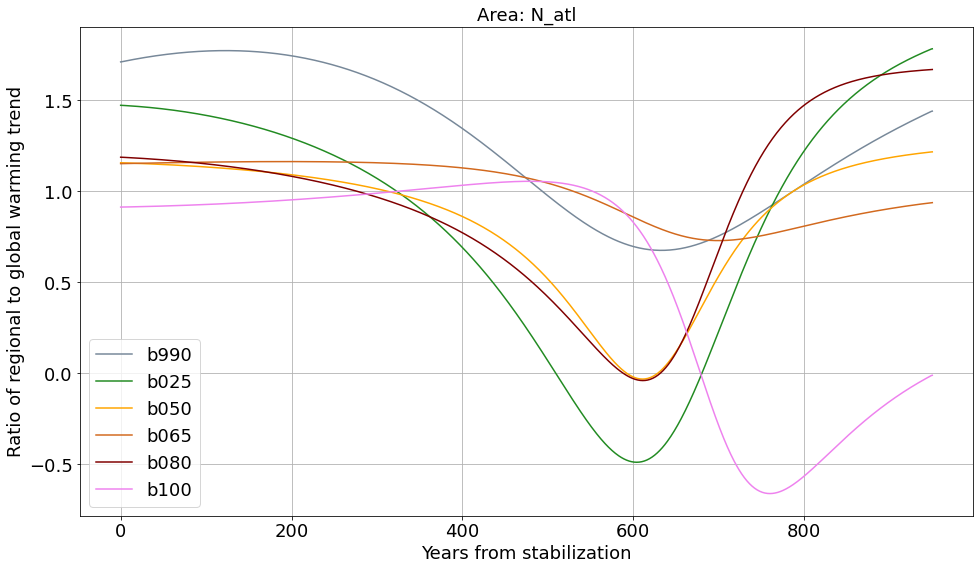

In [146]:
fig

### same for prec

In [151]:
var = 'pr'
yeamean = pickle.load(open(cart_in + 'bottino_seasmean_2D_{}_1000.p'.format(var), 'rb'))

In [152]:
piclim_orig = yeamean_pi[('pi', var)].mean('year')

Med = (-10, 35., 30., 45.)
IndOc = (80., 120., -10., 15.)

areas = [Med, IndOc]
areanams = ['Med', 'IndOc']

regtemp = dict()

for ru in allru[2:-1]:
    print(ru)
    piclim = ctl.regrid_dataset(piclim_orig, regrid_to_reference=yeamean[(ru, var)])
    for area, nam in zip(areas, areanams):
        deltaclim = yeamean[(ru, var)]-piclim
        varok = ctl.sel_area_xr(deltaclim, area)
        varme = ctl.global_mean(varok)

        regtemp[(ru, nam)] = varme


b990
Regridding...


/home/fabiano/local_bin/anaconda3/envs/ctl4/lib/python3.9/site-packages/xarray/core/dataarray.py:780: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


Regridding completed in 0:00:02.857426
Area:  350 35.0 30.0 45.0
Area:  80.0 120.0 -10.0 15.0
b025
Regridding...


/home/fabiano/local_bin/anaconda3/envs/ctl4/lib/python3.9/site-packages/xarray/core/dataarray.py:780: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


Regridding completed in 0:00:02.302773
Area:  350 35.0 30.0 45.0
Area:  80.0 120.0 -10.0 15.0
b050
Regridding...


/home/fabiano/local_bin/anaconda3/envs/ctl4/lib/python3.9/site-packages/xarray/core/dataarray.py:780: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


Regridding completed in 0:00:02.348617
Area:  350 35.0 30.0 45.0
Area:  80.0 120.0 -10.0 15.0
b065
Regridding...


/home/fabiano/local_bin/anaconda3/envs/ctl4/lib/python3.9/site-packages/xarray/core/dataarray.py:780: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


Regridding completed in 0:00:02.304890
Area:  350 35.0 30.0 45.0
Area:  80.0 120.0 -10.0 15.0
b080
Regridding...


/home/fabiano/local_bin/anaconda3/envs/ctl4/lib/python3.9/site-packages/xarray/core/dataarray.py:780: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


Regridding completed in 0:00:02.306684
Area:  350 35.0 30.0 45.0
Area:  80.0 120.0 -10.0 15.0
b100
Regridding...


/home/fabiano/local_bin/anaconda3/envs/ctl4/lib/python3.9/site-packages/xarray/core/dataarray.py:780: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


Regridding completed in 0:00:02.313097
Area:  350 35.0 30.0 45.0
Area:  80.0 120.0 -10.0 15.0


In [159]:
polydeg = 3
tip = 'expfit' # polyfit, butter, expfit

figs_fit = []

for tip in ['polyfit']:
    for area in ['Med', 'IndOc']:
        fig, ax = plt.subplots(figsize = (16,9))
        fig3, ax3 = plt.subplots(figsize = (16,9))

        for ru, col in zip(allru[2:-1], colors[2:-1]):
            print(ru)
            deltatas = glomeans[(ru, var)][1] - pimean[var]

            glo50 = ctl.running_mean(deltatas, 50)
            reg50 = regtemp[(ru, area)].rolling(year = 50, center = True).mean()

            reg50ok = reg50[~np.isnan(reg50)]
            glo50ok = glo50[~np.isnan(glo50)]

            if tip == 'polyfit':
                coeffs1, covmat1 = np.polyfit(np.arange(len(reg50ok)), reg50ok, deg = polydeg, cov = True)
                print(coeffs1)
                fitted1 = np.polyval(coeffs1, np.arange(len(reg50ok)))
            elif tip == 'butter':
                fitted1 = ctl.lowpass_butter(reg50ok, 100)
            elif tip == 'expfit':
                coeffs1, covmat1 = np.polyfit(np.arange(len(reg50ok)), np.log(reg50ok), deg = polydeg, cov = True)
                fitted1 = np.exp(np.polyval(coeffs1, np.arange(len(reg50ok))))

            reg50diff = np.gradient(fitted1)

            if tip == 'polyfit':
                coeffs2, covmat2 = np.polyfit(np.arange(len(reg50ok)), glo50ok, deg = polydeg, cov = True)
                print(coeffs2)
                fitted2 = np.polyval(coeffs2, np.arange(len(reg50ok)))
            elif tip == 'butter':
                fitted2 = ctl.lowpass_butter(glo50ok, 100)
            elif tip == 'expfit':
                coeffs2, covmat2 = np.polyfit(np.arange(len(reg50ok)), np.log(glo50ok), deg = polydeg, cov = True)
                fitted2 = np.exp(np.polyval(coeffs2, np.arange(len(reg50ok))))

            glo50diff = np.gradient(fitted2)

            # Check fit
            fig2, ax2 = plt.subplots(figsize = (16,9))
            ax2.scatter(np.arange(len(reg50ok)), reg50ok, color = col, s = 2, facecolor = 'white')
            ax2.plot(np.arange(len(reg50ok)), fitted1, color = col, lw = 2)

            # ax2.scatter(np.arange(len(reg50ok)), glo50ok, color = col, s = 2)
            # ax2.plot(np.arange(len(reg50ok)), fitted2, color = col, lw = 2)
            # #fig2.savefig(cart_out + 'fit_tas_{}_{}.pdf'.format(area, ru))
            ax2.set_title('{} - {}'.format(area, ru))
            figs_fit.append(fig2)

            #ax.plot(reg50diff/glo50diff, label = ru, color = col)
            ax.plot(reg50diff, label = ru, color = col)
            ax3.plot(fitted1, label = ru, color = col)

        for auu in [ax, ax3]:
            auu.grid()
            auu.legend()
            auu.set_title('Area: {}'.format(area))
            auu.set_xlabel('Years from stabilization')

        ax.set_ylabel('Regional precipitation trend')
        ax3.set_ylabel('Regional precipitation anomaly')

        fig.savefig(cart_out + 'regvsglo_{}_{}_{}_trend.pdf'.format(area, var, tip))
        fig3.savefig(cart_out + 'regvsglo_{}_{}_{}_anom.pdf'.format(area, var, tip))

    ctl.plot_pdfpages(figs=figs_fit, filename=cart_out + 'fit_{}_regvsglo_{}.pdf'.format(var, tip))

b990
[ 1.03746197e-15 -1.49004064e-12  6.58172049e-10 -5.46785585e-07]
[ 1.09626131e-15 -1.82101864e-12  1.19564594e-09  4.30185116e-07]
b025
[ 3.14292886e-15 -2.73612357e-12  3.53785943e-10  5.61714952e-08]
[ 1.99588508e-15 -3.87313676e-12  2.74789804e-09  1.04814165e-06]
b050
[ 1.54427113e-15 -2.58657066e-12  1.09022010e-09 -7.34533590e-07]
[ 3.38111607e-15 -6.47295056e-12  4.35651648e-09  1.96636556e-06]
b065
[ 8.08975571e-16 -4.64301123e-13  3.31079208e-10 -1.53871668e-06]
[ 3.33405786e-15 -6.91685786e-12  5.22762335e-09  2.77343467e-06]
b080
[ 2.14851140e-15 -3.17823801e-12  1.46565838e-09 -2.12510060e-06]
[ 4.68803005e-15 -9.55836553e-12  6.89830060e-09  3.52133498e-06]
b100
[ 2.87386799e-16 -8.98290557e-13  8.79994271e-10 -2.78505213e-06]
[ 4.26334227e-15 -9.59913638e-12  7.44361455e-09  4.72098530e-06]
b990
[ 5.09560882e-15 -9.55223705e-12  5.52433808e-09 -2.69201542e-06]
[ 1.09626131e-15 -1.82101864e-12  1.19564594e-09  4.30185116e-07]
b025
[ 1.14568849e-14 -2.18846371e-11  1.